# Support Vector Machine (SVM) Classifier

This notebook implements an SVM classifier for protein interaction prediction with cross-validation and visualization.


In [56]:
import sys
import os
sys.path.append('..')  # Add parent directory to path

from FeatureExtraction import clean_data, extract_features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    confusion_matrix, 
    precision_score,
    recall_score,
    classification_report
)
from sklearn.preprocessing import StandardScaler
from imblearn.metrics import specificity_score

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)


## Define Metric Functions

Following the same pattern as GradientBoosting notebook.


In [57]:
# Precision functions for each class
def prec_nonDRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["nonDRNA"], average=None, zero_division=0)

def prec_DNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["DNA"], average=None, zero_division=0)

def prec_RNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["RNA"], average=None, zero_division=0)

def prec_DRNA(y_true, y_pred):
    return precision_score(y_true, y_pred, labels=["DRNA"], average=None, zero_division=0)

# Recall functions for each class
def rec_nonDRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["nonDRNA"], average=None, zero_division=0)

def rec_DNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["DNA"], average=None, zero_division=0)

def rec_RNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["RNA"], average=None, zero_division=0)

def rec_DRNA(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=["DRNA"], average=None, zero_division=0)

# Specificity functions for each class
def spe_nonDRNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['nonDRNA'])[0]

def spe_DNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['DNA'])[0]

def spe_RNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['RNA'])[0]

def spe_DRNA(y_true, y_pred):
    return specificity_score(y_true, y_pred, average=None, labels=['DRNA'])[0]

print("Metric functions defined successfully")


Metric functions defined successfully


## Load and Prepare Data


In [58]:
# Load data
data = pd.read_csv('../training_dataset.csv')


## Prepare Features and Labels


In [59]:
# Separate features and labels
X = data.drop('class', axis=1)
y = data['class']


## Scale Features

SVM is sensitive to feature scaling, so we normalize the features.


In [60]:
# Scale features (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


## Initialize SVM Classifier


In [61]:
# Initialize SVM classifier
# Using RBF kernel (default) - can also try 'linear', 'poly', 'sigmoid'
svm_classifier = SVC(
    kernel='rbf',           # Radial Basis Function kernel
    C=1.0,                  # Regularization parameter (higher = less regularization)
    gamma='scale',          # Kernel coefficient ('scale' uses 1/(n_features * X.var()))
    random_state=42,
    probability=True        # Enable probability estimates for predict_proba
)


## 5-Fold Cross-Validation


In [62]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get predictions using cross-validation
y_pred = cross_val_predict(svm_classifier, X_scaled, y, cv=skf)

## Calculate Metrics (Precision, Recall, Specificity)


In [63]:
# Calculate metrics for each class
classes = ['DNA', 'RNA', 'DRNA', 'nonDRNA']

# Map class names to function names
prec_funcs = {'DNA': prec_DNA, 'RNA': prec_RNA, 'DRNA': prec_DRNA, 'nonDRNA': prec_nonDRNA}
rec_funcs = {'DNA': rec_DNA, 'RNA': rec_RNA, 'DRNA': rec_DRNA, 'nonDRNA': rec_nonDRNA}
spe_funcs = {'DNA': spe_DNA, 'RNA': spe_RNA, 'DRNA': spe_DRNA, 'nonDRNA': spe_nonDRNA}

metrics = {}
for cls in classes:
    metrics[cls] = {
        'Precision': prec_funcs[cls](y, y_pred)[0],
        'Recall': rec_funcs[cls](y, y_pred)[0],
        'Specificity': spe_funcs[cls](y, y_pred)
    }

# Create results DataFrame
results_df = pd.DataFrame(metrics).T
results_df.index.name = 'Class'

print("="*80)
print("PERFORMANCE METRICS")
print("="*80)
print(results_df.round(4))
print("="*80)
print(f"\nAverage Precision: {results_df['Precision'].mean():.4f}")
print(f"Average Recall: {results_df['Recall'].mean():.4f}")
print(f"Average Specificity: {results_df['Specificity'].mean():.4f}")
print("="*80)


PERFORMANCE METRICS
         Precision  Recall  Specificity
Class                                  
DNA         0.8519  0.0588       0.9995
RNA         0.8690  0.3805       0.9964
DRNA        0.0000  0.0000       1.0000
nonDRNA     0.9171  0.9964       0.2436

Average Precision: 0.6595
Average Recall: 0.3589
Average Specificity: 0.8099


## Visualizations


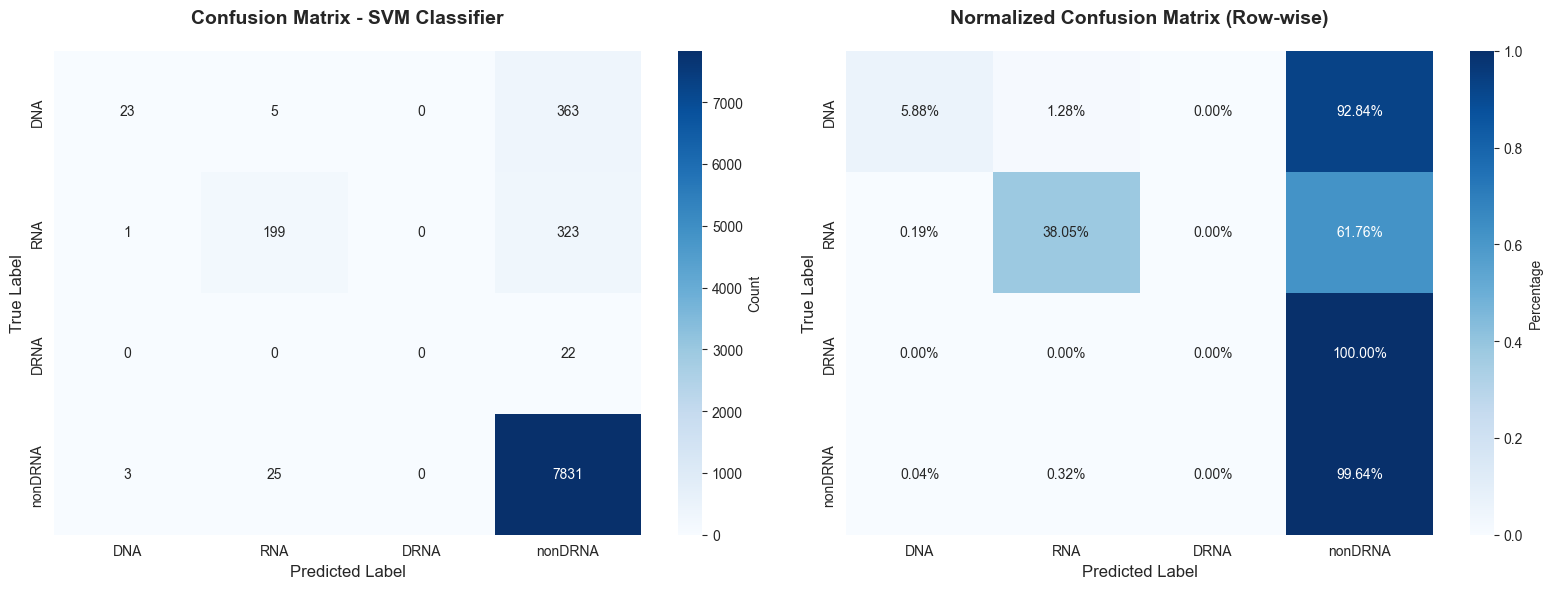

In [64]:
# Confusion Matrix
cm = confusion_matrix(y, y_pred, labels=classes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'}, ax=ax1)
ax1.set_title('Confusion Matrix - SVM Classifier', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage'}, ax=ax2)
ax2.set_title('Normalized Confusion Matrix (Row-wise)', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()


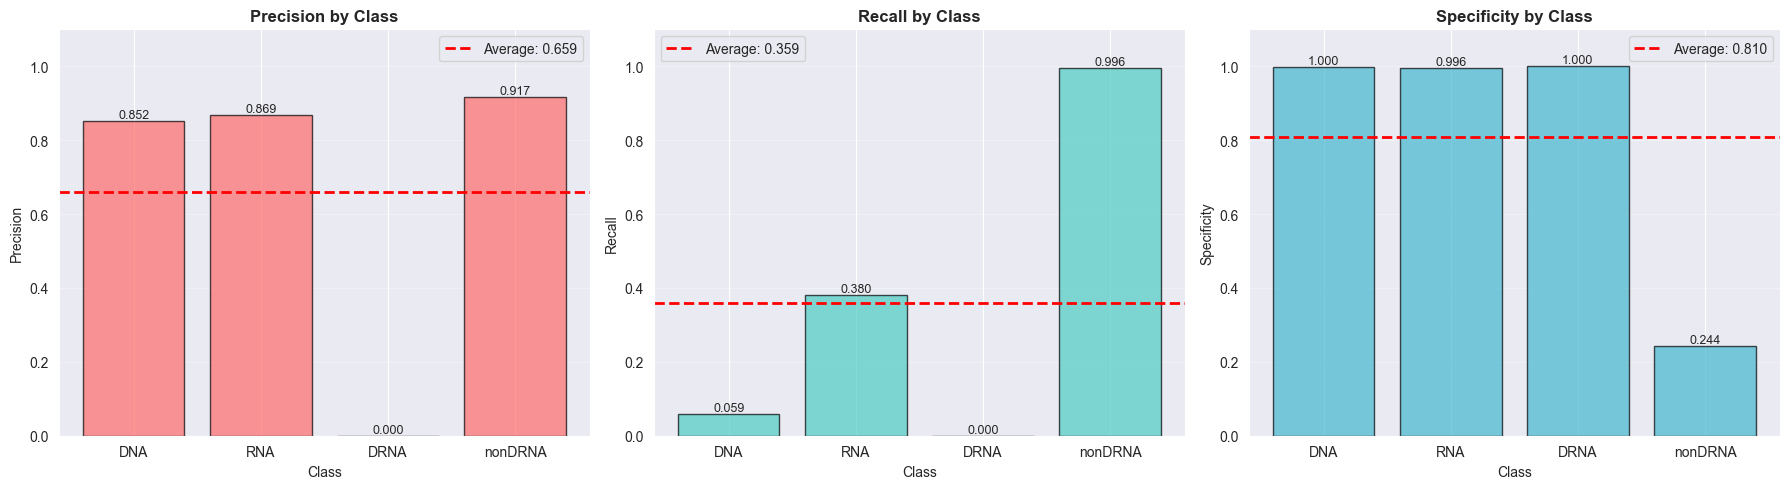

In [65]:
# Metrics comparison by class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['Precision', 'Recall', 'Specificity']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx]
    bars = ax.bar(classes, results_df[metric], color=color, edgecolor='black', alpha=0.7)
    ax.set_title(f'{metric} by Class', fontsize=12, fontweight='bold')
    ax.set_xlabel('Class', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.set_ylim([0, 1.1])
    ax.axhline(y=results_df[metric].mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Average: {results_df[metric].mean():.3f}')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, cls in zip(bars, classes):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


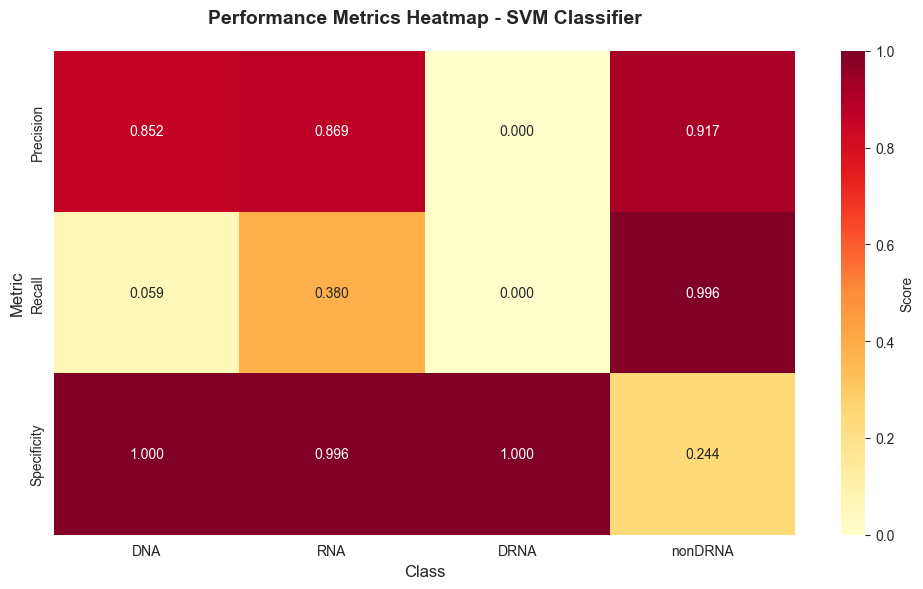

In [66]:
# Heatmap of all metrics
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(results_df.T, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Score'}, ax=ax)
ax.set_title('Performance Metrics Heatmap - SVM Classifier', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Metric', fontsize=12)
plt.tight_layout()
plt.show()


In [67]:
# Classification report
print("\nDetailed Classification Report:")
print("="*80)
print(classification_report(y, y_pred, target_names=classes, digits=4))
print("="*80)



Detailed Classification Report:
              precision    recall  f1-score   support

         DNA     0.8519    0.0588    0.1100       391
         RNA     0.0000    0.0000    0.0000        22
        DRNA     0.8690    0.3805    0.5293       523
     nonDRNA     0.9171    0.9964    0.9551      7859

    accuracy                         0.9156      8795
   macro avg     0.6595    0.3589    0.3986      8795
weighted avg     0.9090    0.9156    0.8898      8795



/Users/CW/CMSC345Project-1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/CW/CMSC345Project-1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/CW/CMSC345Project-1/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

## Summary

- **Model**: Support Vector Machine (SVM) with RBF kernel
- **Cross-Validation**: 5-fold stratified
- **Metrics**: Precision, Recall, Specificity (per class)

### Notes:
- SVM performance can be improved by tuning hyperparameters (C, gamma, kernel)
- Consider using GridSearchCV for hyperparameter optimization
- For large datasets, consider using LinearSVC for faster training


# Support Vector Machine (SVM) Classifier

This notebook implements an SVM classifier for protein interaction prediction with cross-validation and visualization.


In [68]:
import sys
import os
sys.path.append('..')  # Add parent directory to path

from FeatureExtraction import clean_data, extract_features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    confusion_matrix, 
    accuracy_score, 
    classification_report,
    matthews_corrcoef
)
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)


## Load and Prepare Data

In [69]:
# Load data
data = pd.read_csv('../training_dataset.csv')

# print(f"Dataset shape: {data.shape}")
# print(f"\nClass distribution:")
# print(data['class'].value_counts())
# print(f"\nClass percentages:")
# print(data['class'].value_counts(normalize=True) * 100)


## Prepare Features and Labels


In [70]:
# Separate features and labels
X = data.drop('class', axis=1)
y = data['class']

# print(f"Feature matrix shape: {X.shape}")
# print(f"Target vector shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns[0:])}...")  # Show first 10



Feature columns: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']...


## Scale Features

SVM is sensitive to feature scaling, so we normalize the features.


In [71]:
# Scale features (important for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print("Features scaled successfully")
print(f"Scaled feature statistics:")
print(X_scaled.describe().T.head(10))


Features scaled successfully
Scaled feature statistics:
    count          mean       std       min       25%       50%       75%  \
A  8795.0  1.817761e-16  1.000057 -2.556359 -0.725922 -0.132941  0.599819   
C  8795.0  8.604071e-17  1.000057 -0.926695 -0.594833 -0.203332  0.273114   
D  8795.0  2.132840e-16  1.000057 -3.180006 -0.603476 -0.033685  0.580096   
E  8795.0 -1.656183e-16  1.000057 -2.774768 -0.649805 -0.069821  0.555928   
F  8795.0  4.726180e-17  1.000057 -2.564575 -0.681171 -0.081311  0.599637   
G  8795.0  3.651681e-16  1.000057 -3.042066 -0.669965 -0.047448  0.574634   
H  8795.0 -4.039470e-19  1.000057 -1.871302 -0.674164 -0.090196  0.537504   
I  8795.0 -5.816836e-17  1.000057 -2.515404 -0.677699 -0.068394  0.592896   
K  8795.0 -1.615788e-18  1.000057 -2.055912 -0.701369 -0.067174  0.575890   
L  8795.0  6.059205e-17  1.000057 -3.577425 -0.641262 -0.042110  0.586117   

         max  
A   5.223434  
C  18.107568  
D   7.405391  
E   8.995581  
F   6.904573  
G  12.

## Initialize SVM Classifier


In [72]:
# Initialize SVM classifier
# Using RBF kernel (default) - can also try 'linear', 'poly', 'sigmoid'
svm_classifier = SVC(
    kernel='rbf',           # Radial Basis Function kernel
    C=1.0,                  # Regularization parameter (higher = less regularization)
    gamma='scale',          # Kernel coefficient ('scale' uses 1/(n_features * X.var()))
    random_state=42,
    probability=True        # Enable probability estimates for predict_proba
)

## 5-Fold Cross-Validation


In [73]:
# Perform 5-fold stratified cross-validation
print("Performing 5-fold stratified cross-validation...\n")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validation scores
cv_scores = cross_val_score(svm_classifier, X_scaled, y, cv=skf, scoring='accuracy')

print("Cross-Validation Results:")
print(f"Fold scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Min accuracy: {cv_scores.min():.4f}")
print(f"Max accuracy: {cv_scores.max():.4f}")


Performing 5-fold stratified cross-validation...

Cross-Validation Results:
Fold scores: [0.91358727 0.92040932 0.91529278 0.91245026 0.91642979]
Mean accuracy: 0.9156 (+/- 0.0055)
Min accuracy: 0.9125
Max accuracy: 0.9204


## Get Predictions for Evaluation


In [74]:
# Get predictions using cross-validation
y_pred = cross_val_predict(svm_classifier, X_scaled, y, cv=skf)

print("Predictions generated for all samples via cross-validation")
print(f"Predictions shape: {y_pred.shape}")


Predictions generated for all samples via cross-validation
Predictions shape: (8795,)


## Calculate Metrics


In [75]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(y, y_pred)

# Calculate MCC for each class
classes = ['DNA', 'RNA', 'DRNA', 'nonDRNA']
mcc_values = {}

for cls in classes:
    y_true_binary = (y == cls).astype(int)
    y_pred_binary = (y_pred == cls).astype(int)
    mcc = matthews_corrcoef(y_true_binary, y_pred_binary)
    mcc_values[cls] = mcc

print("="*80)
print("PERFORMANCE METRICS")
print("="*80)
print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"\nMCC Values per Class:")
for cls in classes:
    print(f"  MCC_{cls}: {mcc_values[cls]:.4f}")
print(f"\nAverage MCC: {np.mean(list(mcc_values.values())):.4f}")
print("="*80)


PERFORMANCE METRICS
Overall Accuracy: 0.9156 (91.56%)

MCC Values per Class:
  MCC_DNA: 0.2174
  MCC_RNA: 0.5597
  MCC_DRNA: 0.0000
  MCC_nonDRNA: 0.4403

Average MCC: 0.3043


## Visualizations


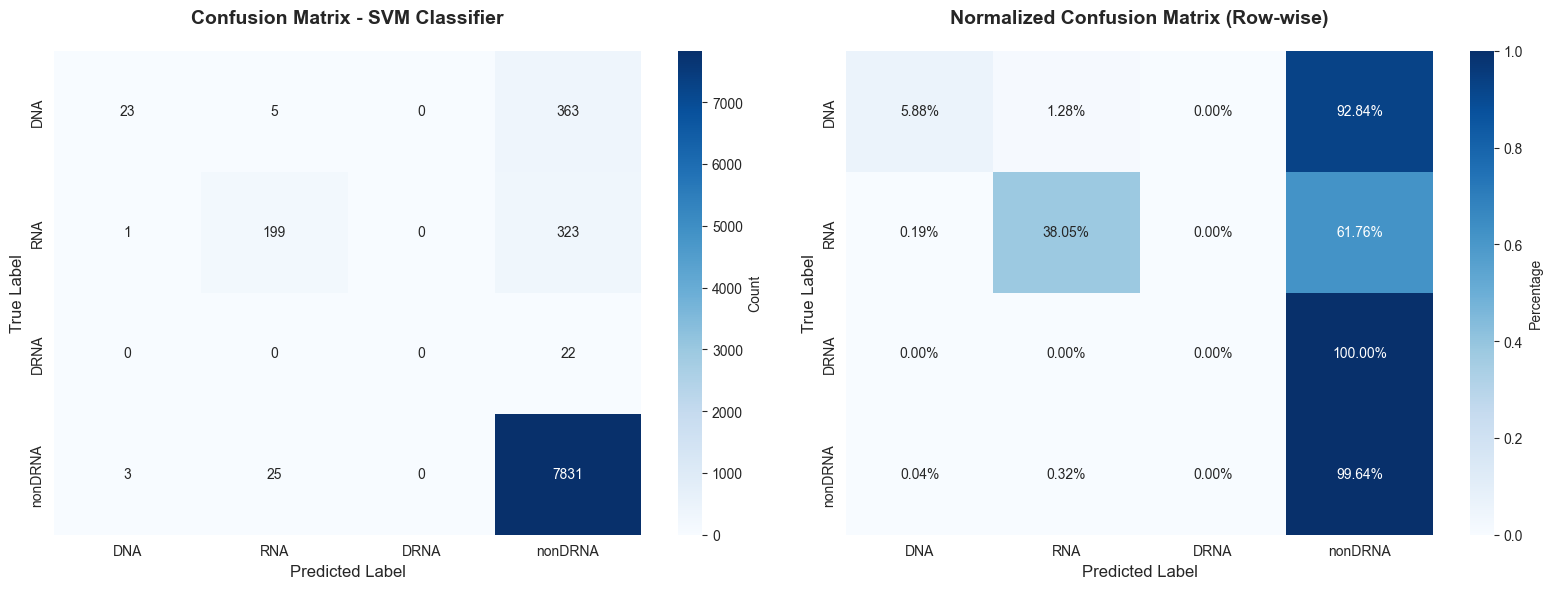

In [76]:
# Confusion Matrix
cm = confusion_matrix(y, y_pred, labels=classes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'}, ax=ax1)
ax1.set_title('Confusion Matrix - SVM Classifier', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Percentage'}, ax=ax2)
ax2.set_title('Normalized Confusion Matrix (Row-wise)', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()


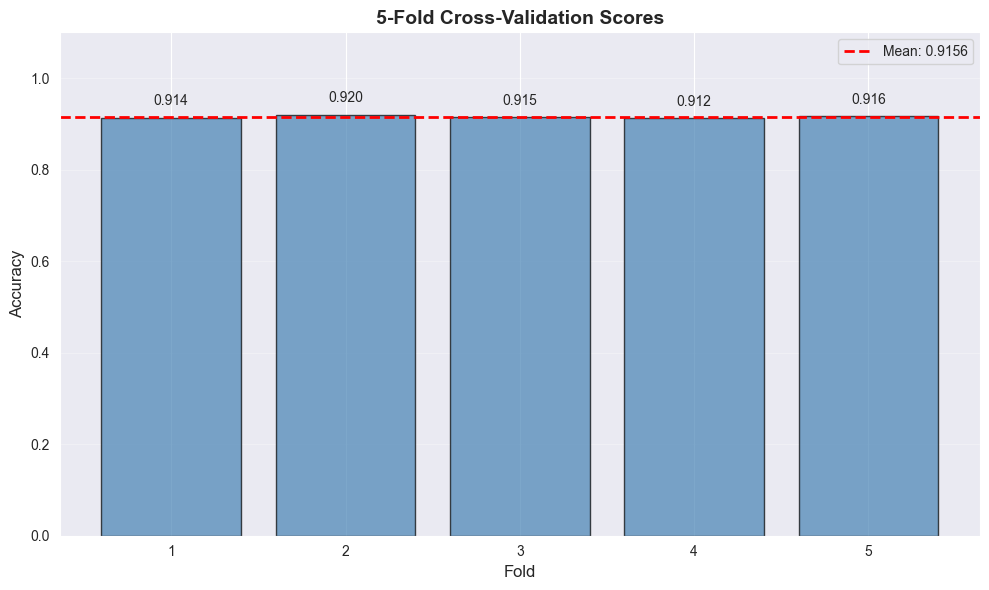

In [77]:
# Cross-validation scores visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(1, 6), cv_scores, color='steelblue', edgecolor='black', alpha=0.7)
ax.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {cv_scores.mean():.4f}')
ax.set_xlabel('Fold', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('5-Fold Cross-Validation Scores', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 6))
ax.set_ylim([0, 1.1])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, score in enumerate(cv_scores):
    ax.text(i+1, score + 0.02, f'{score:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


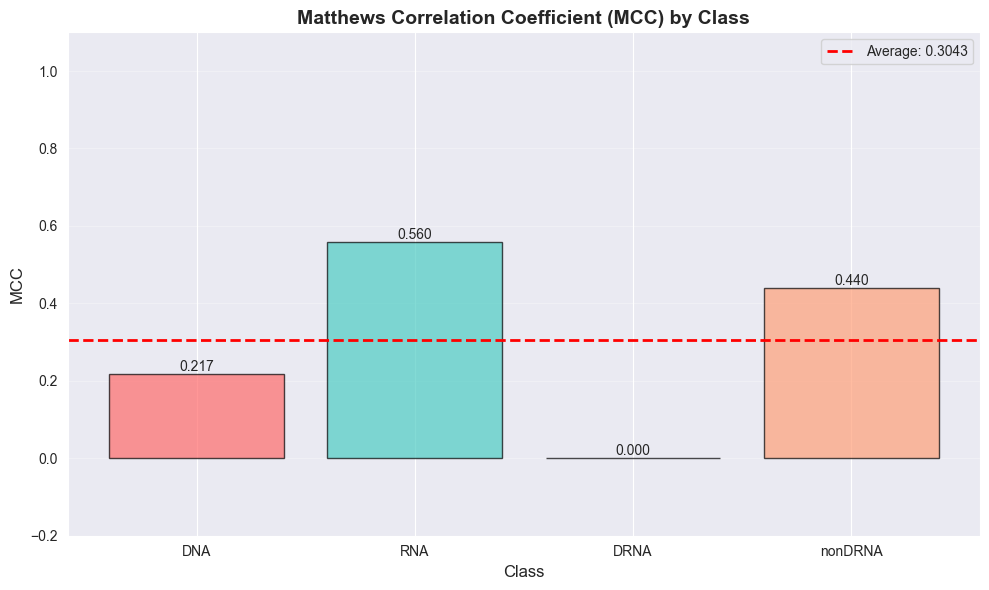

In [78]:
# MCC values visualization
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = ax.bar(classes, [mcc_values[cls] for cls in classes], 
              color=colors, edgecolor='black', alpha=0.7)
ax.set_title('Matthews Correlation Coefficient (MCC) by Class', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('MCC', fontsize=12)
ax.set_ylim([-0.2, 1.1])
ax.axhline(y=np.mean(list(mcc_values.values())), color='red', linestyle='--', 
           linewidth=2, label=f'Average: {np.mean(list(mcc_values.values())):.4f}')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, cls in zip(bars, classes):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mcc_values[cls]:.3f}',
            ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()
